In [1]:
from get_data import get_data, get_data_train, get_data_val
import torch
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from datasets import InMemDataLoader
import torch.nn.functional as F

## Loading datasets

In [2]:
all_paths = []
for root, dirs, files in os.walk(os.path.abspath("/home/ramana44/all_scans_single_channel_equal_dim/")):
    for file in files:
        #print(os.path.join(root, file))
        all_paths.append((os.path.join(root, file)))

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
torch.cuda.is_available()

False

In [5]:
import nibabel as nib

def get_data(paths, device, shuffle=False):
    data = _normalize([_rotate(nib.load(p).get_fdata()) for p in paths])   # load and preprocess all slices from all patients                               
    data_t = torch.FloatTensor(data).to(device)                            # data_t has now the shape: (num_patients, x, y, num_slices)
    data_t = data_t.permute(0, 3, 1, 2)                                    # permute data_t to be in shape (num_patients, num_slices, x, y)
    data_t = data_t[:, :123, :, :]
    data_t = data_t.reshape(data_t.shape[0]*data_t.shape[1],               # reduce dim of data_t to have shape (num_patients*num_slices, x, y)
             data_t.shape[2], data_t.shape[3])
    data_t = data_t.unsqueeze(1)                                           # add image channel, data_t now has shape (num_patients*num_slices, num_channel, x, y)
    if shuffle:                                                            # randomly shuffle all slices
        random_indices = torch.randperm(data_t.shape[0])                   # get list of random indices 
        data_t = data_t[random_indices, :, :, :]                           # reorder the set with the random indices
    return data_t

def _normalize(data):
    data = (data - np.min(data))/(np.max(data)-np.min(data))                # normalize data
    return data                     

def _rotate(data):
    data = np.rot90(data)                                                   # rotate by 90°, without rotation the base of the skull is located to the left of the image       
    return data                                                             # with rotation, the base of the skull is located to the bottom of the image


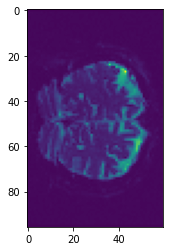

In [6]:
data = nib.load(all_paths[0]).get_fdata()
data = _normalize(_rotate(data))
plt.imshow(data[70])

In [7]:
'''set_ = get_data(all_paths, device)
print(set_.shape)
#plot_images(set_[103:123])
#plt.close()'''

'set_ = get_data(all_paths, device)\nprint(set_.shape)\n#plot_images(set_[103:123])\n#plt.close()'

In [8]:
def get_train_test_set(paths, device, batch_size=32, train_set_size=0.2, test_set_size=0.2):
    assert train_set_size + test_set_size <= 1., "Train and test set size should not exceed 100%"
    
    path_indices = np.arange(len(paths))
    #np.random.shuffle(path_indices)                             # randomize indices of the paths for train and test set selection
    
    num_train = int(np.round_(len(paths) * train_set_size))     # calc amount of training sets to load
    num_test = int(np.round_(len(paths) * test_set_size))       # calc amount of test sets to load
    train_indices = path_indices[:num_train]                    # select unique and random indices from all paths
    test_indices = path_indices[-num_test:]   # for train and test set


    train_data = get_data([paths[i] for i in train_indices], device)  # only load specific indices preveiously selected
    test_data = get_data([paths[i] for i in test_indices], device)

    train_loader = InMemDataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True) # init dataloader for train and test set
    test_loader = InMemDataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True) 
    return train_loader, test_loader

## Plotting for evaluation

In [9]:
train_loader, test_loader = get_train_test_set(all_paths, device, batch_size=200, train_set_size=0.4)

In [11]:
# load trained rAE and bAE
from models import AE
from activations import Sin

path = '/home/ramana44/oasis_mri_2d_slices_PH_in_lat_spc/output/MRT_full/test_run_saving/'
#specify hyperparameters
reg_nodes_sampling = 'legendre'
alpha = 0.0001
frac = 0.8
hidden_size = 1000
deg_poly = 20
latent_dim = 80
lr = 0.0001
no_layers = 5

name = '_'+reg_nodes_sampling+'_'+str(frac)+'_'+str(alpha)+'_'+str(hidden_size)+'_'+str(deg_poly)+'_'+str(latent_dim)+'_'+str(lr)+'_'+str(no_layers)

no_channels, dx, dy = (train_loader.dataset.__getitem__(1).shape)
inp_dim = [no_channels, dx, dy]
model_reg = AE(inp_dim, hidden_size, latent_dim, no_layers, Sin()).to(device)
model_base = AE(inp_dim, hidden_size, latent_dim, no_layers, Sin()).to(device)

#model_reg.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu'))["model"])
#model_base.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu'))["model"])

model_reg.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu')))
model_base.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu')))
#model_reg.eval()
#model_base.eval()

<All keys matched successfully>

torch.Size([20, 9216])
torch.Size([20, 1, 96, 96])
torch.Size([1, 96, 96])
torch.Size([1, 96, 96])
torch.Size([96, 96])


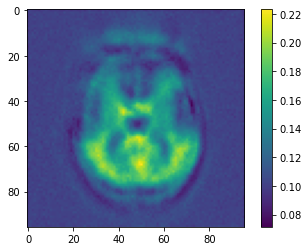

In [12]:
batch_val = next(iter(test_loader))[:20]

reconstruction_val = model_reg(next(iter(test_loader))[:20])
print(reconstruction_val.shape)
reconstruction_val = reconstruction_val.view(batch_val.shape)
print(reconstruction_val.shape)
print(reconstruction_val[0,:].shape)
print(reconstruction_val[0,:].reshape(1, 96, 96).shape)
print(reconstruction_val[0,:].reshape(1, 96, 96).squeeze(0).shape)
plt.imshow(reconstruction_val[1,:].reshape(1, 96, 96).squeeze(0).detach().cpu().numpy())
plt.colorbar()

In [13]:
def computeC1Loss(cheb_nodes, model, device, guidanceTerm = True):
    # extends C1 loss by guidance term
    noNodes, szLatDim = cheb_nodes.shape
    I = torch.eye(szLatDim).to(device) # extract values of all minor diagonals (I = 1) 
    f = lambda x: model.encoder(model.decoder(x.to(device))) # loop through autoencoder
    Jac = torch.autograd.functional.jacobian(f, cheb_nodes.to(device), create_graph = True)
    #Jac = Jac.unsqueeze(1).unsqueeze(3)
    #print("Shape Jacobian: ", Jac.shape)
    loss_C1_arr = torch.zeros(noNodes).to(device)
    inum = 0
    for i in range(cheb_nodes.shape[0]):
    #for node_points in cheb_nodes:
        #node_points = torch.reshape(node_points, (1, szLatDim))
        #Jac = torch.autograd.functional.jacobian(f, node_points.to(device), create_graph = True).squeeze() # compute Jacobian
        loss_C1 = torch.mean((Jac[i,:,i,:] - I)**2)
        if(guidanceTerm):
            min_diag_val = torch.mean((torch.diagonal(Jac[i,:,i,:], dim1 = 0, dim2 = 1) - 1)**2)
            loss_C1 = loss_C1 + min_diag_val
        loss_C1_arr[inum] = loss_C1
        inum += 1
        
    #calculate jacobian of all the nodes together    
    Jac = torch.autograd.functional.jacobian(f, cheb_nodes.to(device), create_graph = True).squeeze() # compute Jacobian
    return torch.mean(loss_C1_arr), Jac

In [14]:
Jac_val_pts = torch.FloatTensor(  np.random.uniform(-1,1,size=(4, latent_dim))   ).to(device)
noNodes, szLatDim = Jac_val_pts.shape
I = torch.eye(szLatDim).to(device) # extract values of all minor diagonals (I = 1)
print(I.shape)
f = lambda x: model_reg.encoder(model_reg.decoder(x.to(device))) # loop through autoencoder
Jac = torch.autograd.functional.jacobian(f, Jac_val_pts.to(device), create_graph = True).squeeze()

torch.Size([20, 20])


In [15]:
x = torch.randn(2, 5, 4, 2)
print(x.shape)
torch.diagonal(x, dim1 = 1, dim2 = 2)

torch.Size([2, 5, 4, 2])


tensor([[[ 0.4742, -2.2303,  0.3281, -1.1675],
         [-0.2654, -0.7823,  2.0234, -1.4256]],

        [[ 0.6373,  1.6670,  0.7155, -0.9291],
         [-0.3920, -0.3513, -1.9114, -0.0648]]])

In [16]:
#torch.diagonal(Jac[0,0])

In [17]:
batch_x = next(iter(test_loader))
print(batch_x.shape)
batch_x = batch_x[0]
print(batch_x.shape)
batch_x = batch_x.view(batch_x.size(0), -1)
print(batch_x.shape)
Jac_val_pts = model_reg.encoder(batch_x.squeeze(1).to(device))
print(Jac_val_pts.shape)
_, Jac = computeC1Loss(Jac_val_pts, model_reg, device)
print(Jac.shape)
#magicNo, _, _, _ = Jac.shape

torch.Size([200, 1, 96, 96])
torch.Size([1, 96, 96])
torch.Size([1, 9216])
torch.Size([1, 20])
torch.Size([20, 20])


In [18]:
Jac.unsqueeze(0).unsqueeze(2).shape

torch.Size([1, 20, 1, 20])

In [19]:
batch_x = next(iter(test_loader))

In [20]:
batch_x.shape

torch.Size([200, 1, 96, 96])

In [15]:
def plot_images(images):
    w = 12
    h = 12
    fig = plt.figure(figsize=(10, 10))
    columns = 5
    rows = 4
    for i in range(1, columns*rows +1):
        img = images[i-1][0].detach().cpu().numpy()
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.colorbar()
        plt.axis('off')
    plt.show()

In [10]:
from torchvision import transforms
transform = transforms.Compose([transforms.ColorJitter(brightness=0.5, hue=0.3)])

In [13]:
batch_x = next(iter(train_loader))

In [24]:
batch_x.shape

torch.Size([200, 1, 96, 96])

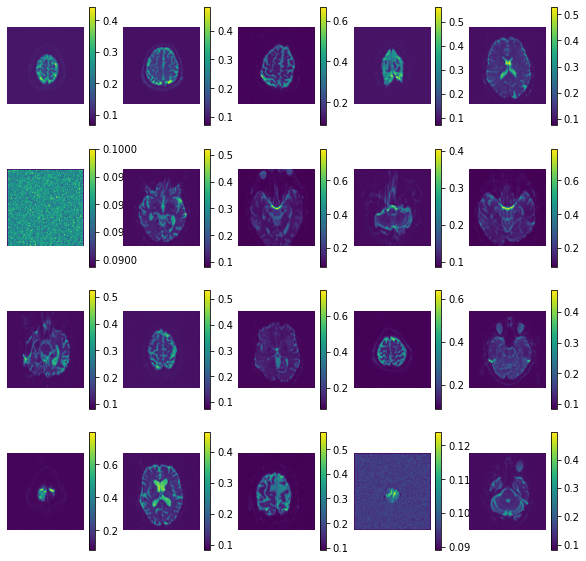

In [16]:
plot_images(batch_x[:20])

### Reconstructions baseline AE

In [13]:
rec_bAE = model_base(batch_x).view(batch_x.shape)
rec_bAE.shape


torch.Size([200, 1, 96, 96])

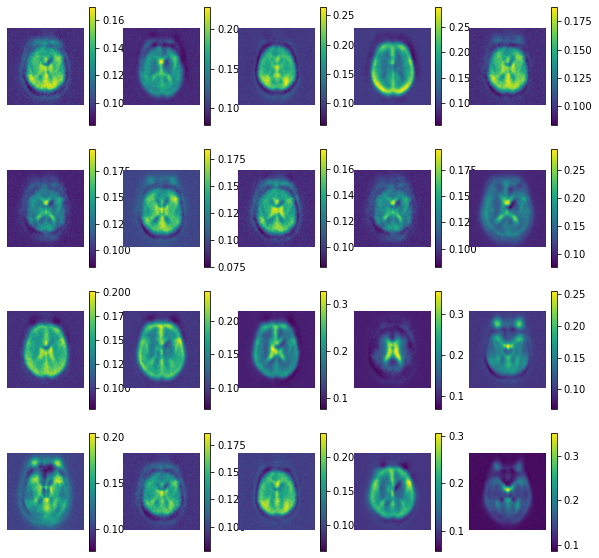

In [14]:
rec_bAE = model_base(batch_x).view(batch_x.shape)
plot_images(rec_bAE[:20])

### Reconstructions regularized AE

In [36]:
test_im = batch_x[0].reshape(1,1,batch_x.shape[2], batch_x.shape[3])
test_im.shape

torch.Size([1, 1, 96, 96])

In [37]:
rec_rAE = model_reg(test_im).view(test_im.shape)
#plot_images(rec_rAE[:20])

<function matplotlib.pyplot.close(fig=None)>

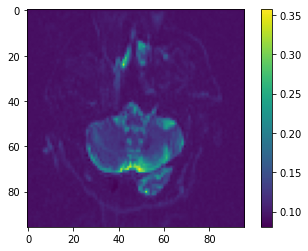

In [26]:

plt.imshow(batch_x[0].squeeze(0).detach().cpu().numpy())
plt.colorbar()
plt.close

<function matplotlib.pyplot.close(fig=None)>

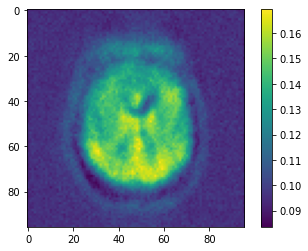

In [25]:
plt.imshow(rec_bAE[0].squeeze(0).detach().cpu().numpy())
plt.colorbar()
plt.close

<function matplotlib.pyplot.close(fig=None)>

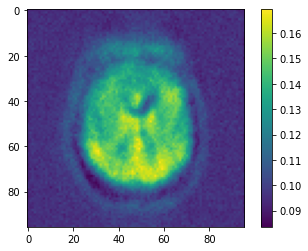

In [24]:
plt.imshow(rec_rAE[0].squeeze(0).detach().cpu().numpy())
plt.colorbar()
plt.close

## PSNR and SSIM

In [ ]:
def batch_psnr(batch_prediction, batch_target):
    avg_psnr = 0
    for i in range(batch_prediction.size(0)):
        mse = F.mse_loss(batch_prediction[i], batch_target[i])
        if mse > 0.:
            psnr = 10 * torch.log10(1 / mse)
            avg_psnr += psnr
        else:
            avg_psnr += 100.

    return (avg_psnr / batch_prediction.size(0)).item()

In [ ]:
psnr_rAE = batch_psnr(rec_rAE, batch_x)
psnr_bAE = batch_psnr(rec_bAE, batch_x)
print("PSNR rAE: %.2f, bAE: %.2f" % (psnr_rAE, psnr_bAE))

PSNR rAE: 14.93, bAE: 14.93


In [ ]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM


In [ ]:
ssim_val = ssim( rec_rAE, batch_x, data_range=255, size_average=False) # return (N,)
ssim_val.shape

torch.Size([200])

In [ ]:
ssim_val

tensor([0.9954, 0.9952, 0.9977, 0.9964, 0.9951, 0.9947, 0.9940, 0.9926, 0.9945,
        0.9935, 0.9949, 0.9971, 0.9929, 0.9939, 0.9951, 0.9972, 0.9935, 0.9937,
        0.9929, 0.9952, 0.9944, 0.9960, 0.9948, 0.9959, 0.9930, 0.9933, 0.9937,
        0.9936, 0.9971, 0.9975, 0.9934, 0.9952, 0.9943, 0.9946, 0.9955, 0.9945,
        0.9937, 0.9936, 0.9934, 0.9952, 0.9932, 0.9946, 0.9969, 0.9954, 0.9945,
        0.9955, 0.9958, 0.9939, 0.9949, 0.9958, 0.9946, 0.9951, 0.9964, 0.9953,
        0.9934, 0.9937, 0.9939, 0.9938, 0.9947, 0.9951, 0.9947, 0.9943, 0.9935,
        0.9936, 0.9943, 0.9967, 0.9929, 0.9934, 0.9951, 0.9953, 0.9935, 0.9942,
        0.9935, 0.9953, 0.9927, 0.9936, 0.9949, 0.9952, 0.9970, 0.9956, 0.9932,
        0.9936, 0.9935, 0.9955, 0.9959, 0.9962, 0.9944, 0.9934, 0.9942, 0.9944,
        0.9941, 0.9933, 0.9972, 0.9937, 0.9938, 0.9936, 0.9961, 0.9951, 0.9937,
        0.9941, 0.9972, 0.9953, 0.9949, 0.9942, 0.9950, 0.9936, 0.9927, 0.9957,
        0.9943, 0.9931, 0.9946, 0.9958, 

In [ ]:
import torch
from piq import ssim, SSIMLoss

#x = torch.rand(4, 3, 256, 256, requires_grad=True)
#y = torch.rand(4, 3, 256, 256)

ssim_index = ssim(rec_rAE, batch_x, data_range=250.)

'''loss = SSIMLoss(data_range=1.)
output: torch.Tensor = loss(x, y)
output.backward()'''
ssim_index

AssertionError: Expected values to be greater or equal to 0, got -0.012894387356936932

In [ ]:
ssim_index

NameError: name 'ssim_index' is not defined

## Transformations

In [ ]:
transform_noise = transforms.Compose([
    transforms.ColorJitter(),
    transforms.])

SyntaxError: invalid syntax (413274311.py, line 3)